In [1]:
import json

import numpy as np
import matplotlib.pyplot as plt
import SimpleITK
from scipy.signal import wiener
from scipy import interpolate

def rgb2grey(rgb):
    """
        Creates a luma transformation of an rgb array
        
        :param rgb: a list of arrays
        :type rgb: numpy.ndarray
        :return: the grey array
        :rtype: numpy.ndarray
        
        :Example:
        
        >>> import numpy
        >>> a = numpy.array([1,2,3])
        >>> print(rgb2grey(a))
        [1.8596 1.8596 1.8596]
    """
    luma = rgb[0] * luma_coeff[0] + rgb[1] * luma_coeff[1] + rgb[2] * luma_coeff[2]
    formula = [luma, luma, luma]
    return np.array(formula)

luma_coeff = [0.2126, 0.7152, 0.0722]

def correct_row(row):
        arr = []
        for i in range(9, len(row)-10):
            arr.append(np.mean(row[i-9 : i+1]))
        return np.array(arr)

class Image:
    
    def __init__(self, fn='', fromArray=np.array([])):
        assert fn or fromArray.ndim>=2, "Image must take a filename or a numpy array as a parameter"
        if fn:
            img = SimpleITK.ReadImage(fn)
            self.__filename = fn
            self.__width = img.GetWidth()
            self.__height = img.GetHeight()
            self.__array = SimpleITK.GetArrayFromImage(img)
            self.__array = self.__array / 65535.0
        else:
            self.__filename = None
            self.__width = fromArray.shape[1]
            self.__height = fromArray.shape[0]
            self.__array = fromArray / 65535.0
    
    def get_filename(self):
        return self.__filename
    
    def get_array(self):
        return self.__array
    
    def get_grey_array(self, arr):
        grey_array = []
        for i in range(len(arr)): # not optimized
            inter = []
            for j in range(len(arr[i])):
                inter.append(rgb2grey(arr[i][j]))
            grey_array.append(np.array(inter))

        return np.array(grey_array)
    
    def wiener_filtered(self, arr):
        return wiener(arr)
    
    def streaks_corrected(self, arr):
        return np.apply_along_axis(correct_row, 1, arr)
    
    def get_width(self):
        return self.__width
    
    def get_height(self):
        return self.__height
    
    def show(self, mode=''):
        array = self.get_array()
        dir = 'upper'
        
        if 'r' in mode:
            dir ='lower'
        
        if 'w' in mode:
            array = self.wiener_filtered(array)
        if 'g' in mode:
            array = self.get_grey_array(array)
        if 's' in mode:
            array = self.streaks_corrected(array)
        
        plt.imshow(array, origin=dir)

def get_med_img(arr):
    """
        Creates a median array from a list of arrays
        
        :param arr: a list of arrays
        :type arr: list or numpy.ndarray
        :return: the median array
        :rtype: numpy.ndarray
        
        :Example:
        
        >>> import numpy
        >>> a = numpy.array([[7,8,9],[16,17,18]])
        >>> b = numpy.array([[13,14,15],[4,5,6]])
        >>> c = numpy.array([[1,2,3],[10,11,12]])
        >>> print(get_med_img([a, b, c]))
        [[ 7.  8.  9.]
         [10. 11. 12.]]
    """
    l3d = np.array(arr)
    return np.median(l3d, axis=0)

class Image3d:
    
    def __init__(self, fns, path=''):
        arrays = []
        for i in range(len(fns)):
            img = SimpleITK.ReadImage(path + fns[i])
            arrays.append(SimpleITK.GetArrayFromImage(img))
        self.__arrays = arrays
    
    def get_2dImage(self):
        return Image(fromArray=get_med_img(self.get_array()))
    
    def get_width(self):
        return self.get_2dImage().get_width()
    
    def get_height(self):
        return self.get_2dImage().get_height()
    
    def get_array(self):
        return self.__arrays

class Calibration:
    
    def __init__(self, img):
        self.__image = img
    
    def get_image(self):
        return self.__image
    
    def display_hist(self, array, chan):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.hist(array.flat, color=chan, bins=256)
    
    def fitting(self, strips, dose_values):
        # converting to optical density values
        dor = -np.log10(strips[:, 0]) # red curve
        dog = -np.log10(strips[:, 1]) # green curve
        dob = -np.log10(strips[:, 2]) # blue curve
        rsb = dor / dob # black curve
        
        legend_list = [(rsb, 'k', 'ratio red/blue ODs'), (dor, 'r', 'red optical density'), (dog, 'g', 'green optical density'), (dob, 'b', 'blue optical density')]
        
        fig, ax = plt.subplots(figsize=(13, 15))
        for e in legend_list: # fitting the curves
            # calculates natural cubic spline polynomials
            x = e[0]

            cs = interpolate.CubicSpline(x[::-1], dose_values[::-1])

            xb = np.linspace(min(x), max(x), num=100)

            #ax.plot(x, dose_values, e[1]+'*')
            ax.plot(xb, cs(xb), e[1], label=e[2])
        
        ax.set_xlim(left=0)
        xliml, xlimr = ax.get_xlim()
        ax.set_xticks(np.arange(xliml, xlimr, 0.1))
        ax.legend()
        ax.set_ylabel('Absorbed Dose (cGy)')
        ax.set_xlabel('Color (16 bits / channel)')
        
    
    def program(self, dose_values):
        
        self.display_hist(self.get_image().get_array()[:,:,0].flatten(), 'red')
        self.display_hist(self.get_image().get_array()[:,:,1].flatten(), 'green')
        self.display_hist(self.get_image().get_array()[:,:,2].flatten(), 'blue') # doesn't display idk why
        
        self.get_image().show('r')
        
        # strip management
        strips = [0 for i in range(8)] # list of length 8
        thirdx = self.get_image().get_width()//3 # third of the length of a strip

        # the zone of interest on the strip is as wide as a third of the image and 20 pixels high to be sure that none of the transitions betweens different doses are included
        # the width can be reduced if the dose is localized on a smaller area on the filter

        # splits the image in 8 strips
        for i in range(7, -1, -1):
            centy = (2*i+1)*(self.get_image().get_height()//8)//2 # mid-height of the current strip

            zoi = self.get_image().get_array()[centy-10 : centy+10, thirdx : 2*thirdx] # zone of interest
            strips[i] = (np.mean(zoi[:,:,0]), np.mean(zoi[:,:,1]), np.mean(zoi[:,:,2]))

        strips = np.array(strips) # contains the median color of each strip
        
        self.fitting(strips, dose_values)

class JsonReader:
    """
    Class to read JSON file and extract useful parameters
    """

    def getInfo(self, filename):
        """
        Returns information from the specified JSON file
        :param filename: path to file
        :return: dict
        """
        with open(filename, 'r') as f:
            data = json.load(f)
        return data["params"]

    def getVariables(self, filename):
        """
        Returns the 'input_variables' field from the specified JSON file
        :param filename: path to file
        :return: dict
        """
        with open(filename, 'r') as f:
            data = json.load(f)
        return data["input_variables"]
    
    def calibrationFromFile(self, filename):
        params = self.getInfo(filename)

        files = params["files"]
        path  = params["path"]
        doses = params["doses"]
        
        w = params["weiner"]
        g = params["grey"]
        s = params["streaks"]

        img = Image3d(files, path).get_2dImage()
        arr = img.get_array()
        if w:
            arr = img.wiener_filtered(arr)
        if g:
            arr = img.get_grey_array(arr)
        if s:
            arr = img.streaks_corrected(arr)
        
        cali = Calibration(Image(fromArray=arr*65535.0))
        cali.program(doses)


blank filter : (0.6940916475928891, 0.679554516098268, 0.48227853131914244) 

[0.69409165 0.50522475 0.45010877 0.41006612 0.37979103 0.35443049
 0.28861238 0.23177455]
[0.67955452 0.5490343  0.50060488 0.46236841 0.43209569 0.40532207
 0.33223796 0.26576047]
[0.48227853 0.43757705 0.41637711 0.39896677 0.38461035 0.37065292
 0.33059881 0.28763024]


Text(0.5, 0, 'Color (16 bits / channel)')

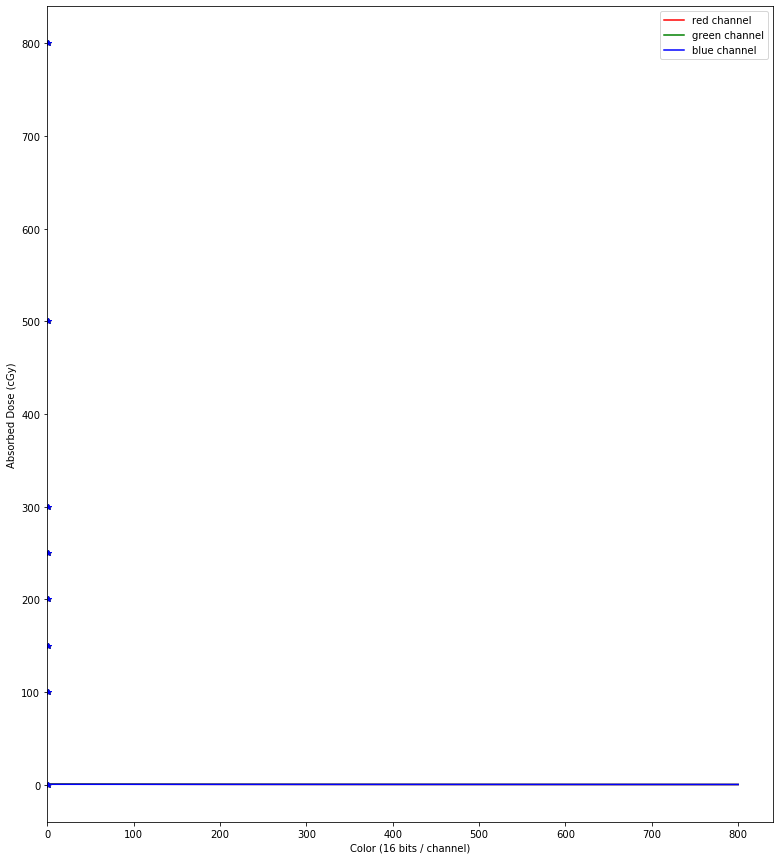

In [7]:
j = JsonReader()

# publication method for the two-step weighting process
params = j.getInfo("../json/default2.json")
variables = j.getVariables("../json/default2.json")
doses = params['doses'][::-1] # on inverse l'array de doses pour qu'il soit dans l'ordre croissant


img1 = Image3d(params['files'], params['path'])
arr = img1.get_2dImage().get_array()



# initialisation des zones d'intérêt
zoi = [] # all of the strips in increasing dose value order(the first one being the unirradiated one)
rois = variables["ROIs"] # les régions d'intérêt ont été calculées à la main et sont indiquées dans le champ "ROIs" du fichier default2.json
for e in rois:
    zoi.append(arr[e[0]:e[1], e[2]:e[3], :])

# calcul de la valeur moyenne des pixels par bande
strips = []
for i in range(len(zoi)):
    strips.append(np.array([np.mean(zoi[i][:,:,0]), np.mean(zoi[i][:,:,1]), np.mean(zoi[i][:,:,2])]))
strips = np.array(strips)

# valeurs de la bande de contrôle
base = (np.mean(zoi[0][:,:,0]), np.mean(zoi[0][:,:,1]), np.mean(zoi[0][:,:,2]))
print('\nblank filter :', base, '\n')

legend_list = [(strips[:, 0], 'r', 'red channel'), (strips[:, 1], 'g', 'green channel'), (strips[:, 2], 'b', 'blue channel')]

fig, ax = plt.subplots(figsize=(13, 15))
for e in legend_list: # fitting the curves
    # calculates natural cubic spline polynomialsa
    x = e[0]
    print(x)

    cs = interpolate.CubicSpline(x[::-1], doses[::-1])

    xb = np.linspace(min(x), max(x), num=100)
    
    ax.plot(x, doses, e[1]+'*')
    ax.plot(cs(xb), xb, e[1], label=e[2])

ax.set_xlim(left=0)
xliml, xlimr = ax.get_xlim()
ax.set_xticks(np.arange(xliml, xlimr, 100))
ax.legend()
ax.set_ylabel('Absorbed Dose (cGy)')
ax.set_xlabel('Color (16 bits / channel)')